In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
nltk.download('stopwords')

import os
# print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
disaster_data=pd.read_csv('./data/disaster_train.csv')
print(disaster_data.shape)
disaster_data.head(10)

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [13]:
disaster_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [14]:
disaster_data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [20]:
train_tweets=disaster_data.text[:5000]
train_sentiments=disaster_data.target[:5000]

test_tweets=disaster_data.text[5000:]
test_sentiments=disaster_data.target[5000:]
print(train_tweets.shape,train_sentiments.shape)
print(test_tweets.shape,test_sentiments.shape)

(5000,) (5000,)
(2613,) (2613,)


In [23]:
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [25]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
disaster_data['text']=disaster_data['text'].apply(denoise_text)

In [26]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
disaster_data['text']=disaster_data['text'].apply(remove_special_characters)

In [27]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
disaster_data['text']=disaster_data['text'].apply(simple_stemmer)

In [28]:
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
disaster_data['text']=disaster_data['text'].apply(remove_stopwords)

{'me', 'doesn', 'those', 'here', 'is', 'as', 'a', 'than', 'before', 'very', 'again', 'into', 'her', 'each', 'the', 'if', 'until', 'are', 'up', "you'll", 'these', 'with', 'ma', 'then', 'having', 'your', "wouldn't", 'and', 'mustn', 'itself', 'couldn', 'them', 'once', 'ain', 'where', 'haven', 'only', 'am', 'yourselves', 'hadn', 'who', 'any', "doesn't", 'our', 'does', "it's", 'you', "don't", 'for', 'just', 'because', "needn't", 'yourself', 'this', 'against', 'mightn', 'above', 'themselves', 'same', "weren't", 'out', 'both', "wasn't", 'now', 'weren', "you've", 'most', 'such', 'd', 've', 'by', 'aren', 'isn', "should've", 'be', 'ourselves', 'my', 'some', 'whom', 'about', 'myself', 'they', 'on', 'do', "hadn't", 'needn', 'himself', 'over', 'she', 'll', 'other', 'there', 'been', 'will', 'should', 'or', 'was', 'own', 'off', 'herself', "isn't", 'more', 'further', "shouldn't", 'we', 'y', 'when', 'so', 'after', 'theirs', 'o', 'he', 'while', 'didn', 'how', "you're", 'too', "won't", 'but', 'can', 'sha

In [29]:
norm_train_tweets=disaster_data.text[:5000]
norm_train_tweets[0]

'deed reason thi earthquak may allah forgiv us'

In [34]:
norm_test_tweets=disaster_data.text[5000:]
norm_test_tweets[5002]

'universityoflaw peopl die human experi unit 731 japanes militari httptcovvplfqv58p httptcoeg1fskqbv6'

In [35]:
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
cv_train_tweets=cv.fit_transform(norm_train_tweets)
cv_test_tweets=cv.transform(norm_test_tweets)

print('BOW_cv_train:',cv_train_tweets.shape)
print('BOW_cv_test:',cv_test_tweets.shape)

BOW_cv_train: (7613, 122559)
BOW_cv_test: (2613, 122559)


In [36]:
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
tv_train_tweets=cv.fit_transform(norm_train_tweets)
tv_test_tweets=cv.transform(norm_test_tweets)

print('BOW_cv_train:',tv_train_tweets.shape)
print('BOW_cv_test:',tv_test_tweets.shape)

BOW_cv_train: (7613, 122559)
BOW_cv_test: (2613, 122559)


In [38]:
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(disaster_data['target'])
print(sentiment_data.shape)

(7613, 1)


In [43]:
train_sentiments=sentiment_data[:5000]
test_sentiments=sentiment_data[5000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [40]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_tweets,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_tweets,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [41]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_tweets)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_tweets)
print(lr_tfidf_predict)

[0 0 1 ... 1 1 1]
[0 0 1 ... 1 1 1]


In [44]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.9946421737466513
lr_tfidf_score : 0.9946421737466513


In [45]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.99      1.00      1.00      1436
    Negative       1.00      0.99      0.99      1177

    accuracy                           0.99      2613
   macro avg       0.99      0.99      0.99      2613
weighted avg       0.99      0.99      0.99      2613

              precision    recall  f1-score   support

    Positive       0.99      1.00      1.00      1436
    Negative       1.00      0.99      0.99      1177

    accuracy                           0.99      2613
   macro avg       0.99      0.99      0.99      2613
weighted avg       0.99      0.99      0.99      2613



In [46]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[1167   10]
 [   4 1432]]
[[1167   10]
 [   4 1432]]


<function matplotlib.pyplot.show(close=None, block=None)>

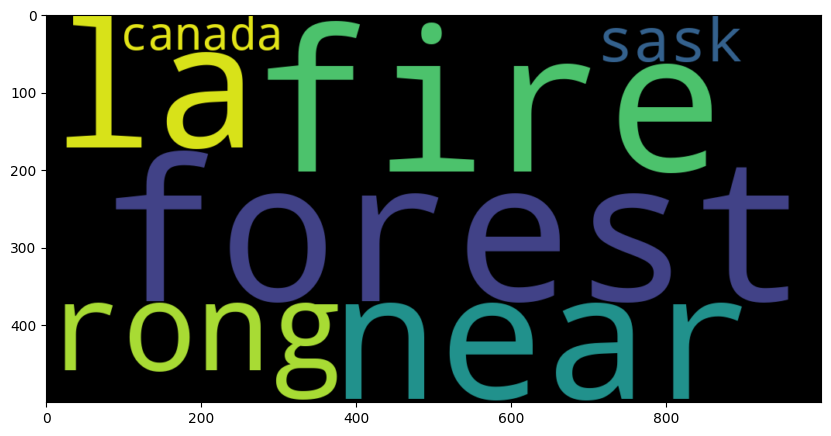

In [47]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_tweets[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

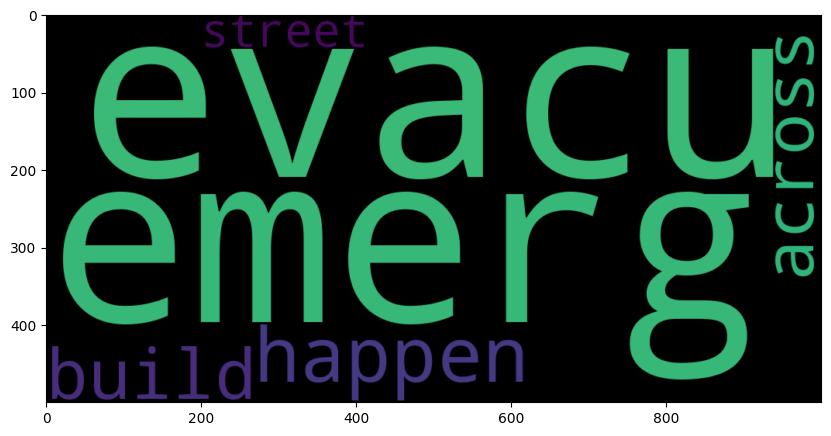

In [48]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_tweets[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show